In [4]:
from qiskit.circuit.library import ZZFeatureMap
from qiskit.circuit.library import RealAmplitudes
from qiskit.opflow import Z, X
from qiskit import Aer
import numpy as np
from qiskit.aqua.components.optimizers import COBYLA, ADAM, SPSA, SLSQP, POWELL, L_BFGS_B, TNC, AQGD
from qiskit_machine_learning.datasets import ad_hoc_data
from sklearn.datasets        import make_circles, make_blobs
from sklearn.model_selection import train_test_split
from matplotlib              import pyplot as plt

In [31]:
class binaryClassifier():
    
    def __init__(self, depth, dim, featureType=None, codType=None):
        self.feature_map = ZZFeatureMap(dim, reps=depth)
        self.ansatz = RealAmplitudes(num_qubits=dim, entanglement='linear', reps=depth)
        self.optParams = list()
    
    def get_expectation(self, dataPoint, params):
        assigned_feature = self.feature_map.assign_parameters(dataPoint)
        assigned_ansatz = self.feature_map.assign_parameters(params)
        circuit = assigned_feature.decompose().compose(assigned_ansatz.decompose())
        circuit.measure_all()
        counts = Aer.get_backend('qasm_simulator').run(circuit, shots=1000).result().get_counts()
        expectations = dict()
        for count in counts.keys():
            parity = sum([int(k) for k in list(count)]) & 1
            if(parity not in expectations):
                expectations.update({parity:counts[count]})
            else:
                expectations[parity] = counts[count] + expectations[parity]
        if(0 in expectations):
            expectations[0] = expectations[0]/1000
        if(1 in expectations):
            expectations[1] = expectations[1]/1000
        return expectations

    def get_cost_mse(self,listExpectation, expected_classes):
        cost = 0
        i = 0
        for c in expected_classes:
            cost += (1 - listExpectation[i][c])**2
            i += 1
        return (1/len(expected_classes)) * cost
        
    def objective_function(self, dataPoints, expected_classes, params):
        expects = list()
        for point in dataPoints:
            expects.append(self.get_expectation(point, params))
        return self.get_cost_mse(expects, expected_classes)
    
    def train(self, X, Y, init_params):
        optimizer = ADAM(maxiter=100, )
        objective_function = lambda params: self.objective_function(X, Y, params)
        opt_params, value, _ = optimizer.optimize(len(init_params), objective_function, initial_point=init_params)
        self.optParams = opt_params
        return opt_params
    
    def predict(self, point):
        expect = self.get_expectation(point, self.optParams)
        if(0 in expect and expect[0] > 0.5):
            return 0
        else:
            return 1

#binary.get_expectation([1,2],[0,1])
#binary.get_cost_mse([dict({0:0.2,1:0.8}),dict({0:0.3,1:0.7})],[1,0])
#binary.objective_function(Xn,yn,[1,2])

## Dataset

In [21]:
X,y = make_blobs(centers=2, n_features=2, n_samples=20, center_box=[(-4,3),(5,-1)],random_state=213)
Xn, Xt, yn, yt = train_test_split(X,y)

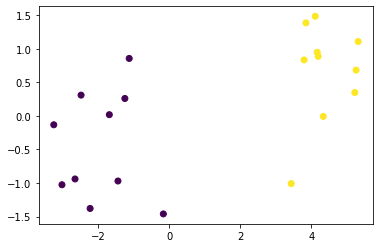

In [22]:
plt.scatter(X[:,0],X[:,1],c=y)

In [32]:
binary = binaryClassifier(depth=1,dim=2)

In [33]:
binary.train(Xn, yn, [1,2])

array([0.99952882, 2.00231138])

In [36]:
binary.predict([4,1.5])

0